In [74]:
import numpy as np
import perceval as pcvl
import perceval.components as comp
import sympy as sp
import random
import math
import matplotlib.pyplot as plt
from scipy import optimize
from perceval.components import catalog
from perceval.converters import QiskitConverter
from perceval.algorithm import Analyzer, Sampler
from perceval.rendering.circuit import SymbSkin, PhysSkin


In [75]:
def generate_random_radians(length):
    radians = []
    for _ in range(length):
        radians.append(comp.PS(random.uniform(0, 2*math.pi)))
    return radians



In [76]:
def build_discriminator_circuit (circuit): 

    phi_index = 30

    list = [0,1,2,4,5,6]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1

    circuit.add((0, 1), comp.BS())
    circuit.add((2, 3), comp.BS())
    circuit.add((4, 5), comp.BS())
    circuit.add((6, 7), comp.BS())

    # list lines with phase shift
    list = [0,2,4,6]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1


    circuit.add((0, 1), comp.BS())
    circuit.add((2, 3), comp.BS())
    circuit.add((4, 5), comp.BS())
    circuit.add((6, 7), comp.BS())

    circuit.add((1, 2), comp.BS())
    circuit.add((5, 6), comp.BS())

    # list lines with phase shift
    list = [1,5]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1

    circuit.add((1, 2), comp.BS())
    circuit.add((5, 6), comp.BS())


    pcvl.pdisplay(circuit, skin=SymbSkin())
    
    return circuit


In [77]:
def build_generator (circuit): 
    
    phi_index = 0

    # list lines with phase shift
    list = [1,2,3,5,6,7]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1

    circuit.add((1, 2), comp.BS())
    circuit.add((5, 6), comp.BS())

    # list lines with phase shift
    list = [1,5]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1

    circuit.add((1, 2), comp.BS())
    circuit.add((5, 6), comp.BS())

    circuit.add((0, 1), comp.BS())
    circuit.add((2, 3), comp.BS())
    circuit.add((4, 5), comp.BS())
    circuit.add((6, 7), comp.BS())

    # list lines with phase shift
    list = [0,2,4,6]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1

    circuit.add((0, 1), comp.BS())
    circuit.add((2, 3), comp.BS())
    circuit.add((4, 5), comp.BS())
    circuit.add((6, 7), comp.BS())

    # list lines with phase shift
    list = [1,5]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1

    circuit.add((1, 2), comp.BS())
    circuit.add((5, 6), comp.BS())

    # list lines with phase shift
    list = [1,5]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1
        
    circuit.add((1, 2), comp.BS())
    circuit.add((5, 6), comp.BS())

    # list lines with phase shift
    list = [0,2,4,6]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1

    circuit.add((0, 1), comp.BS())
    circuit.add((2, 3), comp.BS())
    circuit.add((4, 5), comp.BS())
    circuit.add((6, 7), comp.BS())

    # list lines with phase shift
    list = [0,2,4,6]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1

    circuit.add((0, 1), comp.BS())
    circuit.add((2, 3), comp.BS())
    circuit.add((4, 5), comp.BS())
    circuit.add((6, 7), comp.BS())

    list = [0,1,2,4,5,6]
    for i in list:
        circuit.add(i, comp.PS(pcvl.P(f"phi{phi_index}")))
        phi_index += 1

    # adds the discriminator to this circuit
    #circuit = build_discriminator_circuit(circuit)

    pcvl.pdisplay(circuit, skin=SymbSkin())

    return circuit

In [78]:
# builds the generator+discriminator circuit and the discriminator circuit with given randomized phi values, outputting them in a 2-element list of circuits

def build_circuits ():
    
    generator_circuit = pcvl.Circuit(8)
    discriminator_circuit = pcvl.Circuit(8)

    generator_circuit = build_generator(generator_circuit)
    discriminator_circuit = build_discriminator_circuit(discriminator_circuit)

    return [generator_circuit, discriminator_circuit]
    


[Parameter(name='phi30', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi31', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi32', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi33', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi34', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi35', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi36', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi37', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi38', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi39', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi40', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi41', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi42', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi43', value=None, min_v=0.0, max

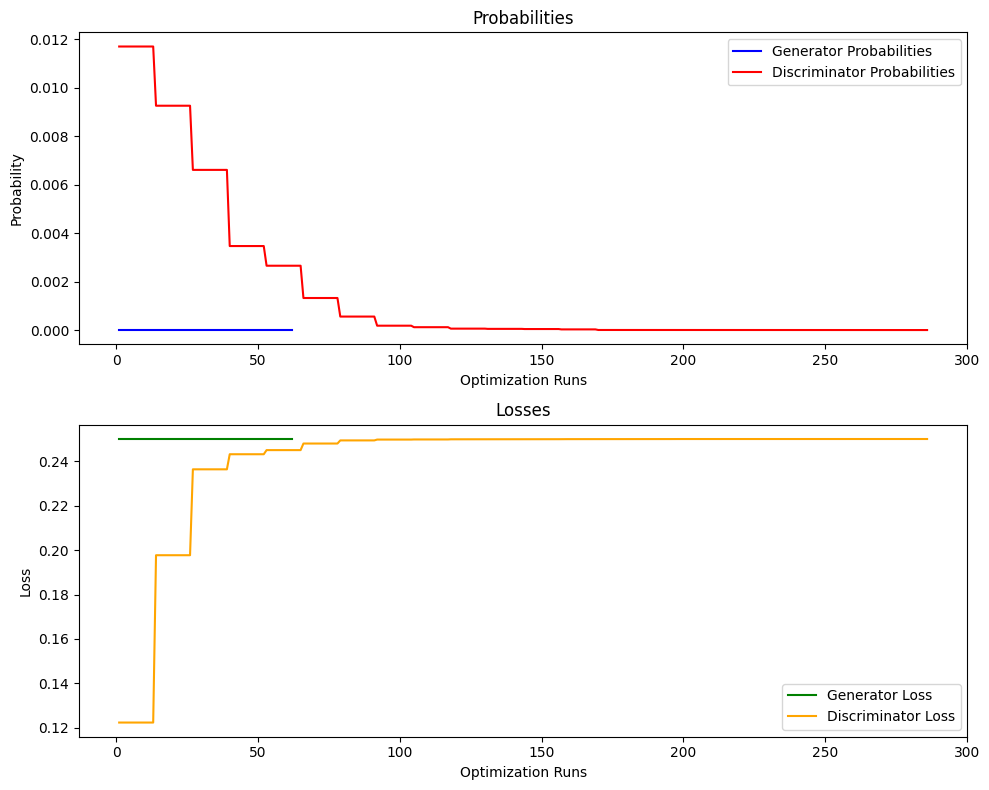

Probability 0.2499999998830733


In [79]:
# get probabilities of the provided and true fock states from their corresponding circuits

provided_fock_state = pcvl.StateVector("|1,0,0,0,1,0,0,0>") + pcvl.StateVector("|0,1,0,0,0,1,0,0>") + pcvl.StateVector("|0,0,1,0,0,0,1,0>") + pcvl.StateVector("|0,0,0,1,0,0,0,1>")
true_fock_state = pcvl.StateVector("|1,0,0,0,0,1,0,0>") + pcvl.StateVector("|0,1,0,0,0,0,1,0>") + pcvl.StateVector("|0,0,1,0,0,0,0,1>") + pcvl.StateVector("|0,0,0,1,1,0,0,0>")
backend = pcvl.BackendFactory.get_backend("SLOS")
## build the circuits with randomized phi values

### build the circuits
circuit_list = build_circuits()
gen_circ = circuit_list[0]
disc_circ = circuit_list[1]



### making the initial parameters
gen_params_circuit = gen_circ.get_parameters()
gen_params_init = [2*random.random()*np.pi for _ in gen_params_circuit]
disc_params_circuit = disc_circ.get_parameters()
disc_params_init = [2*random.random()*np.pi for _ in disc_params_circuit]


print(gen_params_circuit)
print(disc_params_circuit)

def set_parameters_circuit(params_circuit, values):
    for i, value in enumerate(params_circuit):
        params_circuit[i].set_value(values[i])




# gen_and_disc_circ.set_value(gen_params_circuit)
# disc_circ.set_value(disc_params_circuit)

# print(gen_params_circuit)
# print(disc_params_circuit)


## calculate the probability of the generator+discriminator circuit with generated fock state
def compute_gen_probs(gen_circuit, disc_circuit, fock_state):
    genp = pcvl.Processor("SLOS", gen_circuit)
    #discp = pcvl.Processor("SLOS", disc_circuit)
    genp.add(0,disc_circuit)
    genp.with_input(fock_state)
    sampler = pcvl.algorithm.Sampler(genp)
    gen_and_disc_probability = sampler.probs()['results'][pcvl.BasicState([0,0,1,0,0,0,1,0])] ##finds the gen+disk prob of |22>
    return gen_and_disc_probability

def compute_disc_probs(disc_circuit, fock_state):
    discp = pcvl.Processor("SLOS", disc_circuit)
    discp.with_input(fock_state)
    sampler = pcvl.algorithm.Sampler(discp)
    disc_probability = sampler.probs()['results'][pcvl.BasicState([0,0,1,0,0,0,1,0])] ##finds the disk prob of |22>
    return disc_probability


gen_disc_prob_results = []
disc_prob_results = []

gen_loss_results = []
disc_loss_results = []


def gen_loss_function(params):
    set_parameters_circuit(gen_params_circuit, params)
    gen_and_disc_probability = compute_gen_probs(gen_circ, disc_circ, provided_fock_state)
    disc_probability = compute_disc_probs(disc_circ, true_fock_state)
    gen_disc_prob_results.append(disc_probability)
    returnData = np.abs(gen_and_disc_probability - disc_probability)
    gen_loss_results.append(returnData)
    return returnData

def disc_loss_function(params):
    set_parameters_circuit(disc_params_circuit, params)
    gen_and_disc_probability = compute_gen_probs(gen_circ, disc_circ, provided_fock_state)
    disc_probability = compute_disc_probs(disc_circ, true_fock_state)
    disc_prob_results.append(disc_probability)
    returnData = -1*np.abs(gen_and_disc_probability - disc_probability)
    disc_loss_results.append(-returnData)
    return returnData

'''
def gen_loss_function(params):
    for i, value in enumerate(params):
        gen_params_circuit[i].set_value(value)
    backend.set_circuit(gen_and_disc_circ)
    backend.set_input_state(provided_fock_state)
    return np.abs(gen_and_disc_probability - disc_probability)
'''

'''
def disc_loss_function(params):
    for i, value in enumerate(params):
        disc_params_circuit[i].set_value(value)
    backend.set_circuit(disc_circ)
    backend.set_input_state(true_fock_state)
    return -np.abs(gen_and_disc_probability - disc_probability)
'''
set_parameters_circuit(gen_params_circuit, gen_params_init)
set_parameters_circuit(disc_params_circuit, disc_params_init)

gen_params = gen_params_init
disc_params = disc_params_init

for _ in range(2):
    #optimize params

    best_disc_parameters = optimize.minimize(disc_loss_function, disc_params, method="L-BFGS-B").x
    for i, value in enumerate(best_disc_parameters):
            disc_params_circuit[i].set_value(value)


    best_gen_parameters = optimize.minimize(gen_loss_function, gen_params, method="L-BFGS-B").x
    for i, value in enumerate(best_gen_parameters):
            gen_params_circuit[i].set_value(value)
    
    #resetting params to optimized version
    gen_params = best_gen_parameters
    disc_params = best_disc_parameters
    print(gen_params)
    print(disc_params)


# PLOT GRAPHS
optimizer_runs = range(1,11)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(range(1, len(gen_disc_prob_results)+1), gen_disc_prob_results, label='Generator Probabilities', color='blue')
axs[0].plot(range(1, len(disc_prob_results)+1), disc_prob_results, label='Discriminator Probabilities', color='red')
axs[0].set_title('Probabilities')
axs[0].set_xlabel('Optimization Runs')
axs[0].set_ylabel('Probability')
axs[0].legend()


axs[1].plot(range(1,len(gen_loss_results)+1), gen_loss_results, label='Generator Loss', color='green')
axs[1].plot(range(1,len(disc_loss_results)+1), disc_loss_results, label='Discriminator Loss', color='orange')
axs[1].set_title('Losses')
axs[1].set_xlabel('Optimization Runs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()

plt.show()



#set_parameters_circuit(gen_params_circuit, best_gen_parameters)
#set_parameters_circuit(disc_params_circuit, best_disc_parameters)


gen_and_disc_probability = compute_gen_probs(gen_circ, disc_circ, provided_fock_state)
print("Probability", gen_and_disc_probability)



# print(sample_count['results'])
# discp.with_input(samples['results'][0])

# sampler2 = pcvl.algorithm.Sampler(discp)
# sample_count = sampler2.sample_count(1000)
# print(sample_count['result'])



#optimization
#gen_o = optimize.minimize(gen_loss_function, gen_params_init, method="L-BFGS-B")
#disc_o = optimize.minimize(disc_loss_function, disc_params_init, method="L-BFGS-B")


#print(f"The loss value for gen+disc circuit is {gen_loss_function(gen_o.x)}")


### resetting the parameters with the loss function




